# Face recognition using neural network features

In this notebook, a face recogniser will be constructed based on features extracted from the neural network. The following consists of two parts: image classification (where distinct images are classified) and video classification (which involves short video sequences).

This was completed as part of the Computer Vision course of the Advanced Machine Learning Specialisation on Coursera.

In [1]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter
import pandas as pd
from skimage.io import imread

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
import zipfile

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

def unpack(filename):
    with zipfile.ZipFile(filename) as zf:
        zf.extractall()

In [4]:
unpack('Face_Recognition_data.zip')

### Reading data for image and video classification 

The function 𝚕𝚘𝚊𝚍_𝚒𝚖𝚊𝚐𝚎_𝚍𝚊𝚝𝚊 returns a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3D numpy arrays (for images) or strings with the names (for labels).

In [5]:
def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    train_data, train_labels, test_data, test_labels = {}, {}, {}, {}
    for filename in os.listdir(os.path.join(dir_name, 'train/images')):
        input_image = imread(os.path.join(dir_name, 'train/images', filename))
        if len(input_image.shape) == 2:
            img = gray2rgb(input_image)
        train_data[filename] = input_image
    for filename in os.listdir(os.path.join(dir_name, 'test', 'images')):
        input_image = imread(os.path.join(dir_name, 'test/images', filename))
        if len(input_image.shape) == 2:
            input_image = gray2rgb(input_image)
        test_data[filename] = input_image
    
    csv_file = pd.read_csv(os.path.join(dir_name, 'train/y_train.csv'))
    for filename, class_id in zip(csv_file['filename'], csv_file['class_id']):
        train_labels[filename] = class_id   
    csv_file = pd.read_csv(os.path.join(dir_name, 'test/y_test.csv'))
    for filename, class_id in zip(csv_file['filename'], csv_file['class_id']):
        test_labels[filename] = class_id
    return train_data, train_labels, test_data, test_labels

In [6]:
x_train, y_train, x_test, y_test = load_image_data()
print(len(x_train), '\ttraining images')
print(len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [7]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    # Fixed: added list
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

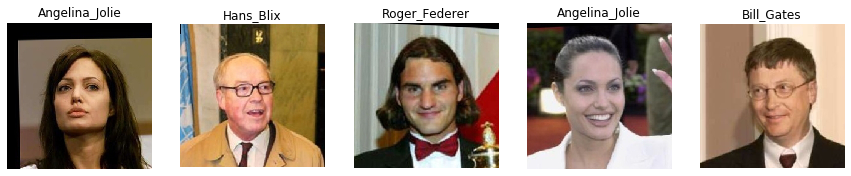

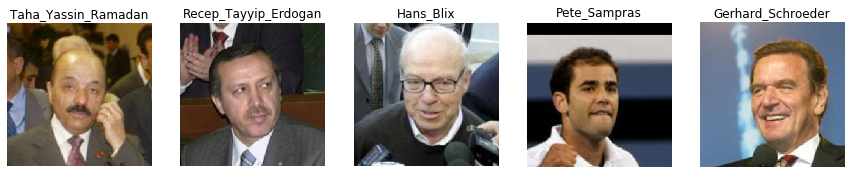

In [8]:
visualize(x_train, y_train)
visualize(x_test, y_test)

The function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ returns a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as for the image classification dataset. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [9]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    video_train, train_labels, video_test, test_labels = {}, {}, {}, {}
    for filename in os.listdir(os.path.join(dir_name, 'train/images')):
        img = imread(os.path.join(dir_name, 'train/images', filename))
        if len(img.shape) == 2:
            img = gray2rgb(img)
        video_train[filename] = img
    for video in os.listdir(os.path.join(dir_name, 'test/videos')):
        video_test[video] = []
        for filename in os.listdir(os.path.join(dir_name, 'test/videos', video)):
            img = imread(os.path.join(dir_name, 'test/videos', video, filename))
            if len(img.shape) == 2:
                img = gray2rgb(img)
            video_test[video].append(img)
            
    csv_file = pd.read_csv(os.path.join(dir_name, 'train/y_train.csv'))
    for filename, class_id in zip(csv_file['filename'], csv_file['class_id']):
        train_labels[filename] = class_id
    csv_file = pd.read_csv(os.path.join(dir_name, 'test/y_test.csv'))
    for filename, class_id in zip(csv_file['filename'], csv_file['class_id']):
        test_labels[str(filename)] = class_id
    return video_train, train_labels, video_test, test_labels

In [10]:
video_train, train_labels, video_test, test_labels = load_video_data()
print(len(video_train), '\ttraining images')
print(len(video_test), '\ttesting videos')

729 	training images
70 	testing videos


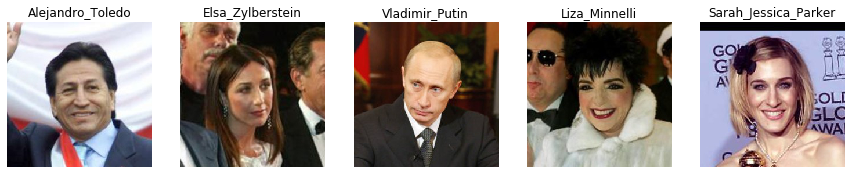

In [11]:
visualize(video_train, train_labels)

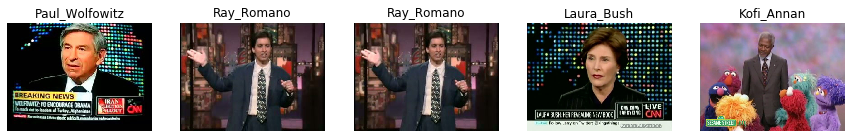

In [12]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing

The preprocessing function receives a list of images as an input, detects the face on each image, finds the facial keypoints, and then crops and normalises the image according to these keypoints. The output of this function is the list of images that contain only the aligned face.

In [13]:
from skimage import transform 
import dlib

SAMPLE_SHAPE = (224, 224)

def preprocess_imgs(imgs, is_video=False):
   
    face_detector = dlib.get_frontal_face_detector()
    #downloaded from https://github.com/justadudewhohacks/face-recognition.js-models/blob/master/models/shape_predictor_5_face_landmarks.dat
    shape_predict = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

    faces_list = [] 
    detec_list = []

    for img in imgs:
        img_copy = img.copy()
        dtc_g = False
        
        #face detection
        faces, scores, levels = face_detector.run(img_copy)

        if len(faces) > 0:
            face = faces[np.argmax(scores)] 
            dtc_g = True

            #keypoint detection
            kpts = dlib.full_object_detections()
            kpts.append(shape_predict(img_copy, face))
            anchor = kpts[0]

            #adjustments inside bounded box
            a_points = anchor.parts()
            a_rect = anchor.rect
            dtu = 10
            for p in a_points:
                p.y = p.y - dtu    
            a_rect = dlib.rectangle(a_rect.left(),
                                    a_rect.top()-dtu,
                                    a_rect.right(),
                                    a_rect.bottom()-dtu)
            anchor = dlib.full_object_detection(a_rect, a_points)

            #face alignment
            img_copy = dlib.get_face_chip(img_copy, anchor, size=SAMPLE_SHAPE[0], padding=0.6)

        img_copy = transform.resize(img_copy, SAMPLE_SHAPE)
        detec_list.append(dtc_g)
        faces_list.append(img_copy)

    #video frames removed if no faces detected
    faces_list_ret = []
    for img_copy, dtc_g in zip(faces_list, detec_list):
        if (is_video and dtc_g) or (not is_video):
            faces_list_ret.append(img_copy)

    return faces_list_ret  

#### Visualisation of preprocessing

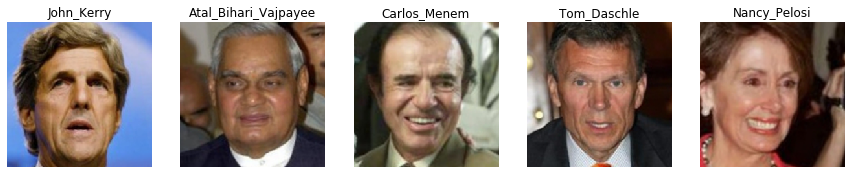

In [14]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

The neural network is pre-trained on another face dataset. This network is used as a feature extractor to get descriptors of the faces. 

In [15]:
import h5py
from keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)      

Here is an example of using the network as a feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so several images can be inputted simultaneously and retrieve their face descriptors of shape (n_images, n_components).

In [16]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [17]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier 

The class $\tt{Classifier}$ is now implemented with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and returns the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

In [18]:
#auxiliary function - return vector of features for training/prediction
def get_features(images):

    feat_fc6 = get_layer_output(images, 'fc6')
    features = np.array(feat_fc6)

    return features

In [19]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.extmath import weighted_mode
#from tqdm import tqdm.notebook as tqdm
from tqdm.notebook import tqdm
import scipy
from skimage.io import imread
import cv2
from os.path import join

class Classifier():
    def __init__(self, nn_model):
        self.model1_mlp = None
        self.lb_encoder = LabelEncoder()

    def fit(self, train_imgs, train_labels):        
        #preprocessing
        train_imgs_lst = []
        train_labels_lst = []
        for f, img in train_imgs.items():
            train_imgs_lst.append(img)
            train_labels_lst.append(train_labels[f])

        train_imgs_lst = preprocess_imgs(train_imgs_lst)
        self.lb_encoder.fit(train_labels_lst)
        n_classes = len(list(self.lb_encoder.classes_))

        x_data = np.array(get_features(np.array(train_imgs_lst)))
        y_data = np.array(self.lb_encoder.transform(train_labels_lst))

        #model training
        x_train, y_train = x_data, y_data
        self.model1_mlp = MLPClassifier(hidden_layer_sizes=(128, ),
                                        alpha=1, 
                                        max_iter=1000) 
        self.model1_mlp.fit(x_train, y_train)

    #auxliary function - classify array of images and returns vector with probabilities
    def _classify_batch(self, imgs, is_video=False):

        imgs_p = preprocess_imgs(imgs, is_video)
        if len(imgs_p) == 0 and is_video:
            return None, None 
        x_test = get_features(np.array(imgs_p))
        y_pred = self.model1_mlp.predict(x_test)
        y_prob_v = self.model1_mlp.predict_proba(x_test)
        y_prob = [p[int(y)] for p, y in zip(y_prob_v, y_pred)]
        return np.array(y_pred, dtype=int32), np.array(y_prob, dtype=float32)

    def classify_images(self, test_imgs):
        test_imgs_lst = []
        test_files_lst = []
        for f, img in test_imgs.items():
            test_imgs_lst.append(img)
            test_files_lst.append(f)
        y_pred, _ = self._classify_batch(test_imgs_lst)
        pred_labels = self.lb_encoder.inverse_transform(y_pred) 
        return {f:l for f, l in zip(test_files_lst, pred_labels)}      
        

    def classify_videos(self, test_video):
        y_pred_dict = {}
        for f, frames in tqdm(test_video.items(), total=len(test_video)):
            y_pred_v, y_prob_v = self._classify_batch(frames, is_video=True)
            if y_pred_v is not None:
                y_pred = weighted_mode(y_pred_v, y_prob_v)[0][0] 
                y_pred_dict[f] = self.lb_encoder.inverse_transform([int(y_pred)])[0]
            else:
                y_pred_dict[f] = ""
        return y_pred_dict

## Building, fitting and predicting with the classifiers

### Image classification

In [20]:
img_classifier = Classifier(model)
img_classifier.fit(x_train, y_train)
y_out = img_classifier.classify_images(x_test)

In [21]:
#function to evaluate accuracy of the classifier

def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1   
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [22]:
#image classification accuracy
print(check_test(y_out, y_test))

Classification accuracy is 0.9703


### Video classification

In [23]:
video_classifier = Classifier(model)
video_classifier.fit(video_train, train_labels)

In [24]:
y_video_out = video_classifier.classify_videos(video_test)

#video classification accuracy
print(check_test(y_video_out, test_labels))


Classification accuracy is 0.8857
